In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

In [2]:
# List the ticker symbols for the stocks of interest
lst_Stocks = ['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]
ticker = ['BNS.TO']

# Determine the Date range for the desired data
start_date = '2014-01-01'
end_date = '2022-12-31'
df = yf.download(ticker, start= start_date, end= end_date)
df = df.sort_index()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Feature Engineering

# Mid Rang Variables
df['Mid_hl'] = (df['High'] + df['Low']) /2 
df['Mid_oc'] = (df['Open'] + df['Close']) /2 
df['Mid_hloc'] = (df['High'] + df['Low'] + df['Open'] + df['Close']) /4 

# Close in Range ==> Close at Low = 0, Close at High = 1
df['Close_in_range'] = 1 - ((df['High'] - df['Close']) / (df['High'] - df['Low']) )

# Daily/Weekly Returns - Average of Open and Close
df['Returns_1Day_Moc'] = df['Mid_oc'].pct_change()
df['Returns_5Day_Moc'] = df['Mid_oc'].pct_change(5)
df['Returns_30Day_Moc'] = df['Mid_oc'].pct_change(30)

# Daily/Weekly Returns - Average of High Low Open Close
df['Returns_1Day_Mhloc'] = df['Mid_hloc'].pct_change()
df['Returns_5Day_Mhloc'] = df['Mid_hloc'].pct_change(5)
df['Returns_30Day_Mhloc'] = df['Mid_hloc'].pct_change(30)

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Moc'] = df['Mid_oc'].rolling(10).std()
df['Std_Dev_30Day_Moc'] = df['Mid_oc'].rolling(30).std()

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Mhloc'] = df['Mid_hloc'].rolling(10).std()
df['Std_Dev_30Day_Mhloc'] = df['Mid_hloc'].rolling(30).std()

# Simple Moving Average - 8 Day vs 20 Day
df['SMA_Returns_8Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(8).std()
df['SMA_Returns_20Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(20).std()
df['SMA_Delta_8_20Day_Mhloc'] = df['SMA_Returns_8Day_Mhloc'] - df['SMA_Returns_20Day_Mhloc']
df['SMA_Signal_8_20Day_Mhloc'] = np.where(df['SMA_Returns_8Day_Mhloc'] < 1, 0, 1) 

# Display
display(df.columns)
display(df.head(10))
display(df.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid_hl',
       'Mid_oc', 'Mid_hloc', 'Close_in_range', 'Returns_1Day_Moc',
       'Returns_5Day_Moc', 'Returns_30Day_Moc', 'Returns_1Day_Mhloc',
       'Returns_5Day_Mhloc', 'Returns_30Day_Mhloc', 'Std_Dev_10Day_Moc',
       'Std_Dev_30Day_Moc', 'Std_Dev_10Day_Mhloc', 'Std_Dev_30Day_Mhloc',
       'SMA_Returns_8Day_Mhloc', 'SMA_Returns_20Day_Mhloc',
       'SMA_Delta_8_20Day_Mhloc', 'SMA_Signal_8_20Day_Mhloc'],
      dtype='object')

Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  66.349998  66.599998  66.010002  66.010002   
2014-01-03 00:00:00-05:00  65.239998  65.519997  64.860001  65.459999   
2014-01-06 00:00:00-05:00  65.459999  65.489998  64.529999  64.739998   
2014-01-07 00:00:00-05:00  64.949997  65.139999  64.470001  64.480003   
2014-01-08 00:00:00-05:00  64.550003  64.660004  64.120003  64.400002   
2014-01-09 00:00:00-05:00  64.589996  64.650002  64.129997  64.510002   
2014-01-10 00:00:00-05:00  64.690002  64.720001  64.279999  64.430000   
2014-01-13 00:00:00-05:00  64.370003  64.660004  64.150002  64.269997   
2014-01-14 00:00:00-05:00  64.489998  64.500000  63.669998  63.680000   
2014-01-15 00:00:00-05:00  63.910000  63.980000  63.580002  63.730000   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  42.832870  2724600  66.305000  66.180000   
2014-01-03 00:00:00-05:00  42.878716  1498600  65.189999  65.349998   
2014-01-06 00:00:00-05:00  42.407093  1937000  65.009998  65.099998   
2014-01-07 00:00:00-05:00  42.236786  1455100  64.805000  64.715000   
2014-01-08 00:00:00-05:00  42.184380  2014100  64.390003  64.475002   
2014-01-09 00:00:00-05:00  42.256432  1332300  64.389999  64.549999   
2014-01-10 00:00:00-05:00  42.204033  1187800  64.500000  64.560001   
2014-01-13 00:00:00-05:00  42.099228  1371900  64.405003  64.320000   
2014-01-14 00:00:00-05:00  41.712749  1905200  64.084999  64.084999   
2014-01-15 00:00:00-05:00  41.745499  1943000  63.780001  63.820000   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2014-01-02 00:00:00-05:00  66.242500        0.000000  ...                 NaN   
2014-01-03 00:00:00-05:00  65.269999        0.909094  ...                 NaN   
2014-01-06 00:00:00-05:00  65.054998        0.218749  ...                 NaN   
2014-01-07 00:00:00-05:00  64.760000        0.014929  ...                 NaN   
2014-01-08 00:00:00-05:00  64.432503        0.518515  ...                 NaN   
2014-01-09 00:00:00-05:00  64.469999        0.730773  ...           -0.026758   
2014-01-10 00:00:00-05:00  64.530001        0.340911  ...           -0.011337   
2014-01-13 00:00:00-05:00  64.362501        0.235284  ...           -0.010645   
2014-01-14 00:00:00-05:00  64.084999        0.012051  ...           -0.010423   
2014-01-15 00:00:00-05:00  63.800000        0.374996  ...           -0.009817   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2014-01-02 00:00:00-05:00                  NaN                NaN   
2014-01-03 00:00:00-05:00                  NaN                NaN   
2014-01-06 00:00:00-05:00                  NaN                NaN   
2014-01-07 00:00:00-05:00                  NaN                NaN   
2014-01-08 00:00:00-05:00                  NaN                NaN   
2014-01-09 00:00:00-05:00                  NaN                NaN   
2014-01-10 00:00:00-05:00                  NaN                NaN   
2014-01-13 00:00:00-05:00                  NaN                NaN   
2014-01-14 00:00:00-05:00                  NaN                NaN   
2014-01-15 00:00:00-05:00                  NaN           0.679908   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2014-01-02 00:00:00-05:00                NaN                  NaN   
2014-01-03 00:00:00-05:00                NaN                  NaN   
2014-01-06 00:00:00-05:00                NaN                  NaN   
2014-01-07 00:00:00-05:00                NaN                  NaN   
2014-01-08 00:00:00-05:00                NaN                  NaN   
2014-01-09 00:00:

Open       High        Low      Close  \
Date                                                                    
2022-12-15 00:00:00-05:00  66.199997  66.400002  65.070000  65.500000   
2022-12-16 00:00:00-05:00  65.050003  65.720001  64.980003  65.239998   
2022-12-19 00:00:00-05:00  65.320000  65.580002  64.059998  64.480003   
2022-12-20 00:00:00-05:00  64.910004  65.949997  64.510002  65.290001   
2022-12-21 00:00:00-05:00  65.720001  66.389999  65.690002  65.860001   
2022-12-22 00:00:00-05:00  65.540001  65.849998  64.919998  65.820000   
2022-12-23 00:00:00-05:00  65.940002  66.400002  65.849998  66.379997   
2022-12-28 00:00:00-05:00  66.480003  66.680000  65.320000  65.440002   
2022-12-29 00:00:00-05:00  65.599998  66.669998  65.459999  66.629997   
2022-12-30 00:00:00-05:00  66.500000  66.610001  65.769997  66.339996   

                           Adj Close    Volume     Mid_hl     Mid_oc  \
Date                                                                   
2022-12-15 00:00:00-05:00  64.483040  10736800  65.735001  65.849998   
2022-12-16 00:00:00-05:00  64.227081  11494100  65.350002  65.145000   
2022-12-19 00:00:00-05:00  63.478882   9698700  64.820000  64.900002   
2022-12-20 00:00:00-05:00  64.276306   5032700  65.230000  65.100002   
2022-12-21 00:00:00-05:00  64.837456   1713200  66.040001  65.790001   
2022-12-22 00:00:00-05:00  64.798073   5739000  65.384998  65.680000   
2022-12-23 00:00:00-05:00  65.349380   3687900  66.125000  66.160000   
2022-12-28 00:00:00-05:00  64.423981  13099800  66.000000  65.960003   
2022-12-29 00:00:00-05:00  65.595497   9330200  66.064999  66.114998   
2022-12-30 00:00:00-05:00  65.309998   4108200  66.189999  66.419998   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2022-12-15 00:00:00-05:00  65.792500        0.323308  ...           -0.033068   
2022-12-16 00:00:00-05:00  65.247501        0.351345  ...           -0.047099   
2022-12-19 00:00:00-05:00  64.860001        0.276319  ...           -0.049078   
2022-12-20 00:00:00-05:00  65.165001        0.541668  ...           -0.046215   
2022-12-21 00:00:00-05:00  65.915001        0.242856  ...           -0.018684   
2022-12-22 00:00:00-05:00  65.532499        0.967743  ...           -0.003952   
2022-12-23 00:00:00-05:00  66.142500        0.963629  ...            0.013717   
2022-12-28 00:00:00-05:00  65.980001        0.088237  ...            0.017268   
2022-12-29 00:00:00-05:00  66.089998        0.966941  ...            0.014195   
2022-12-30 00:00:00-05:00  66.304998        0.678568  ...            0.005917   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2022-12-15 00:00:00-05:00             0.012114           0.931244   
2022-12-16 00:00:00-05:00            -0.006017           1.194178   
2022-12-19 00:00:00-05:00            -0.018834           1.427148   
2022-12-20 00:00:00-05:00            -0.019006           1.532330   
2022-12-21 00:00:00-05:00            -0.003816           1.511919   
2022-12-22 00:00:00-05:00            -0.039500           1.458194   
2022-12-23 00:00:00-05:00            -0.039534           1.284387   
2022-12-28 00:00:00-05:00            -0.037561           1.041283   
2022-12-29 00:00:00-05:00            -0.044977           0.645756   
2022-12-30 00:00:00-05:00            -0.039928           0.506338   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2022-12-15 00:00:00-05:00           1.609817             0.933437   
2022-12-16 00:00:00-05:00           1.641389             1.155591   
2022-12-19 00:00:00-05:00           1.724097             1.398653   
2022-12-20 00:00:00-05:00           1.797250             1.495442   
2022-12-21 00:00:00-05:00           1.816343             1.466575   
2022-

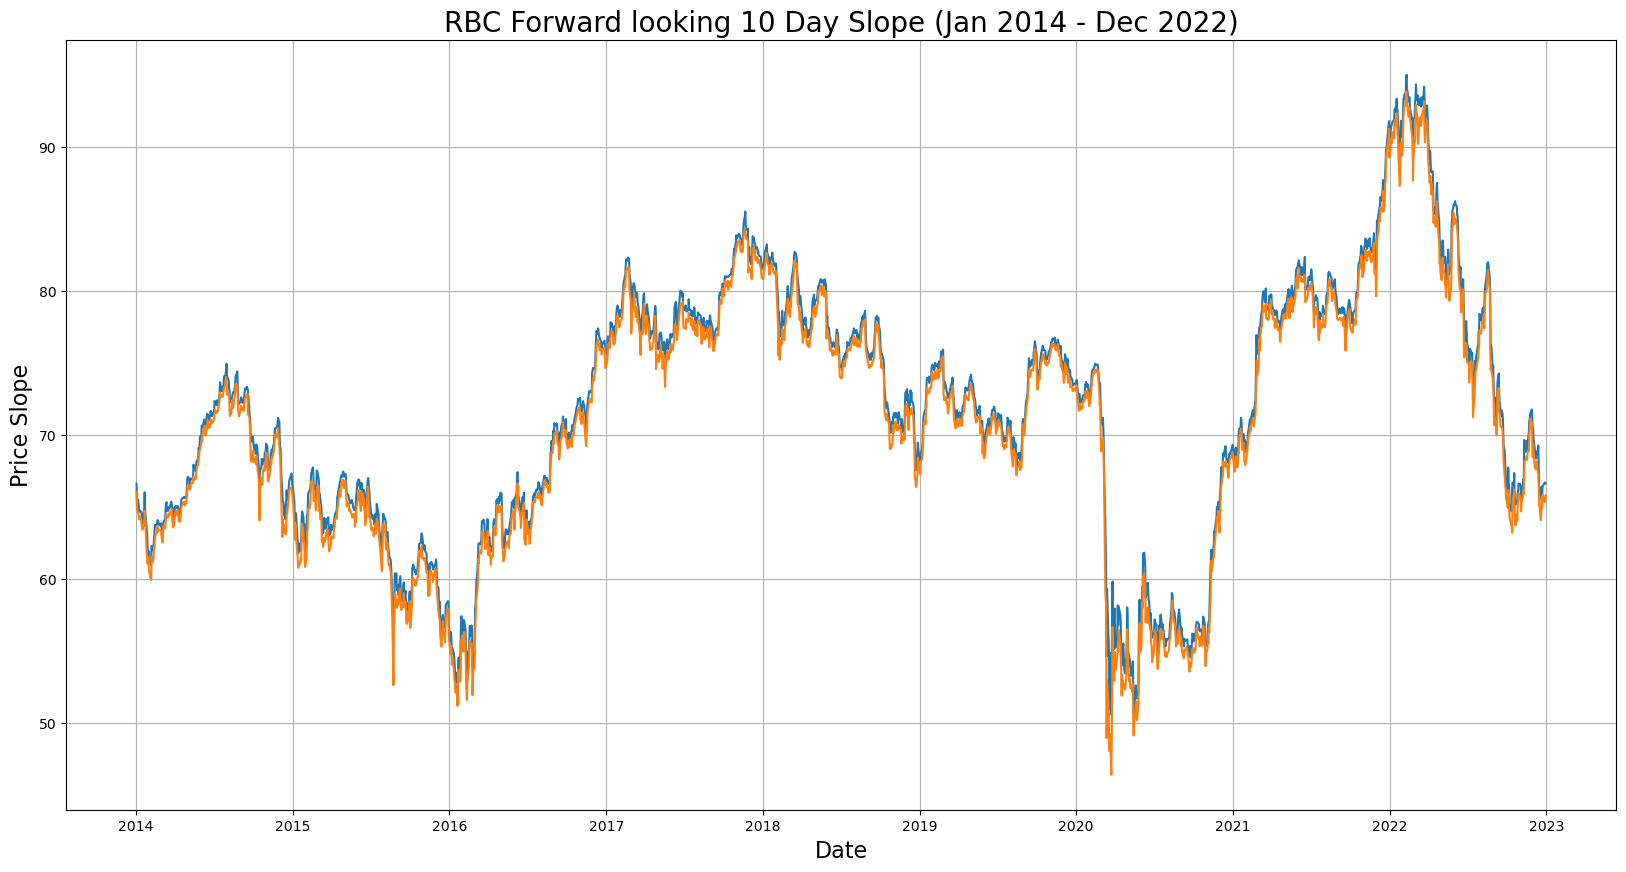

In [4]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['High']], label='High')
plt.plot(df[['Low']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


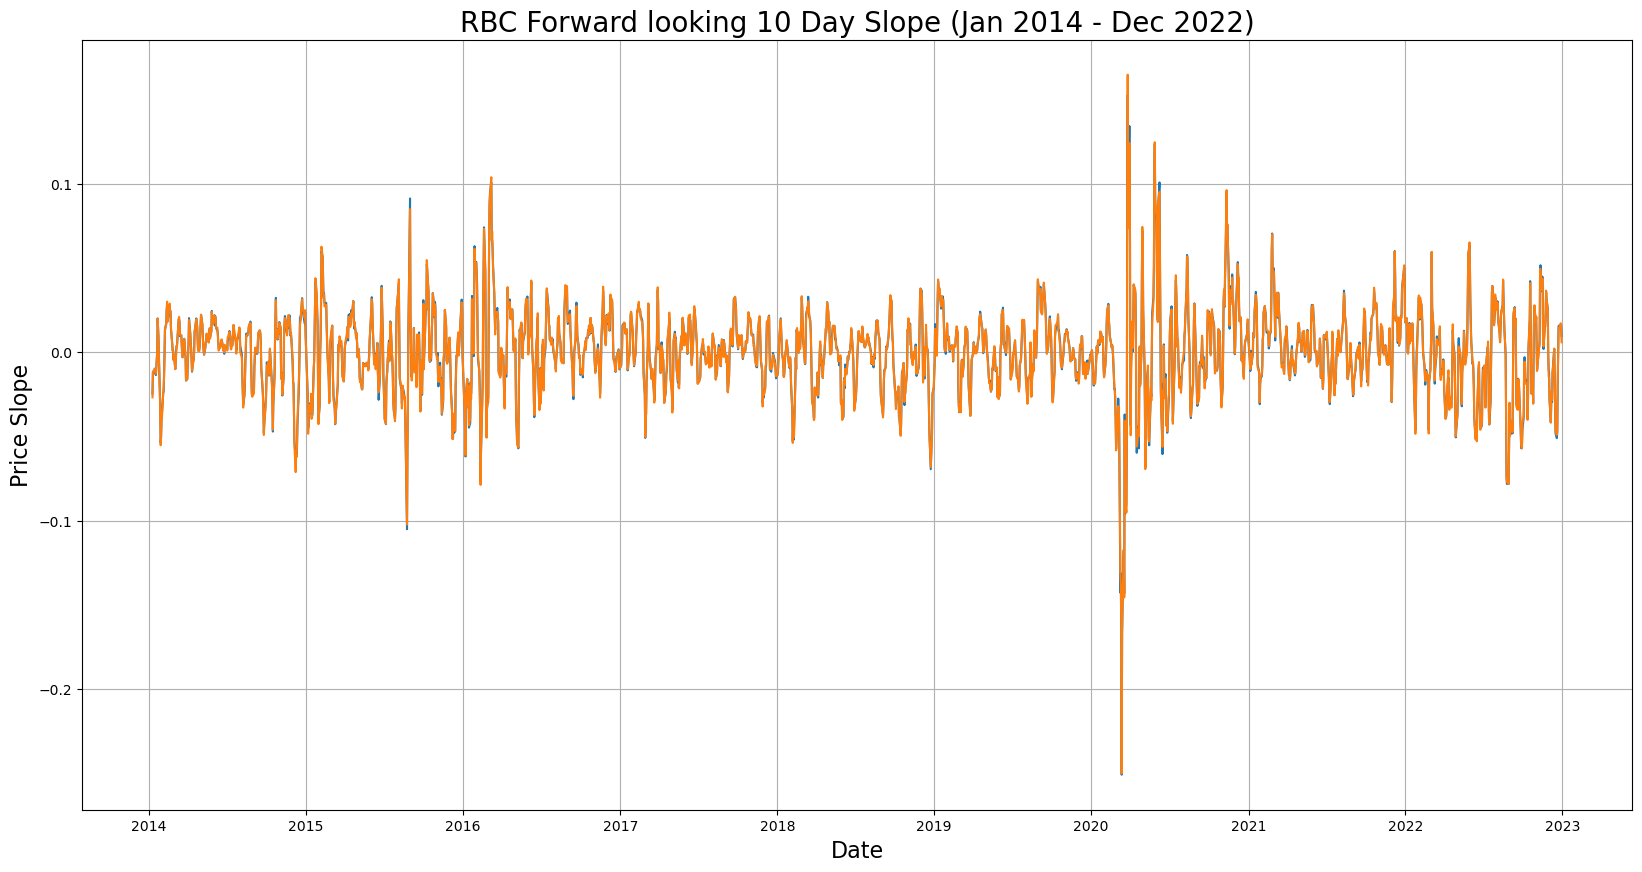

In [5]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Returns_5Day_Moc']], label='Open-Close')
plt.plot(df[['Returns_5Day_Mhloc']], label='High-Low-Open-Close')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


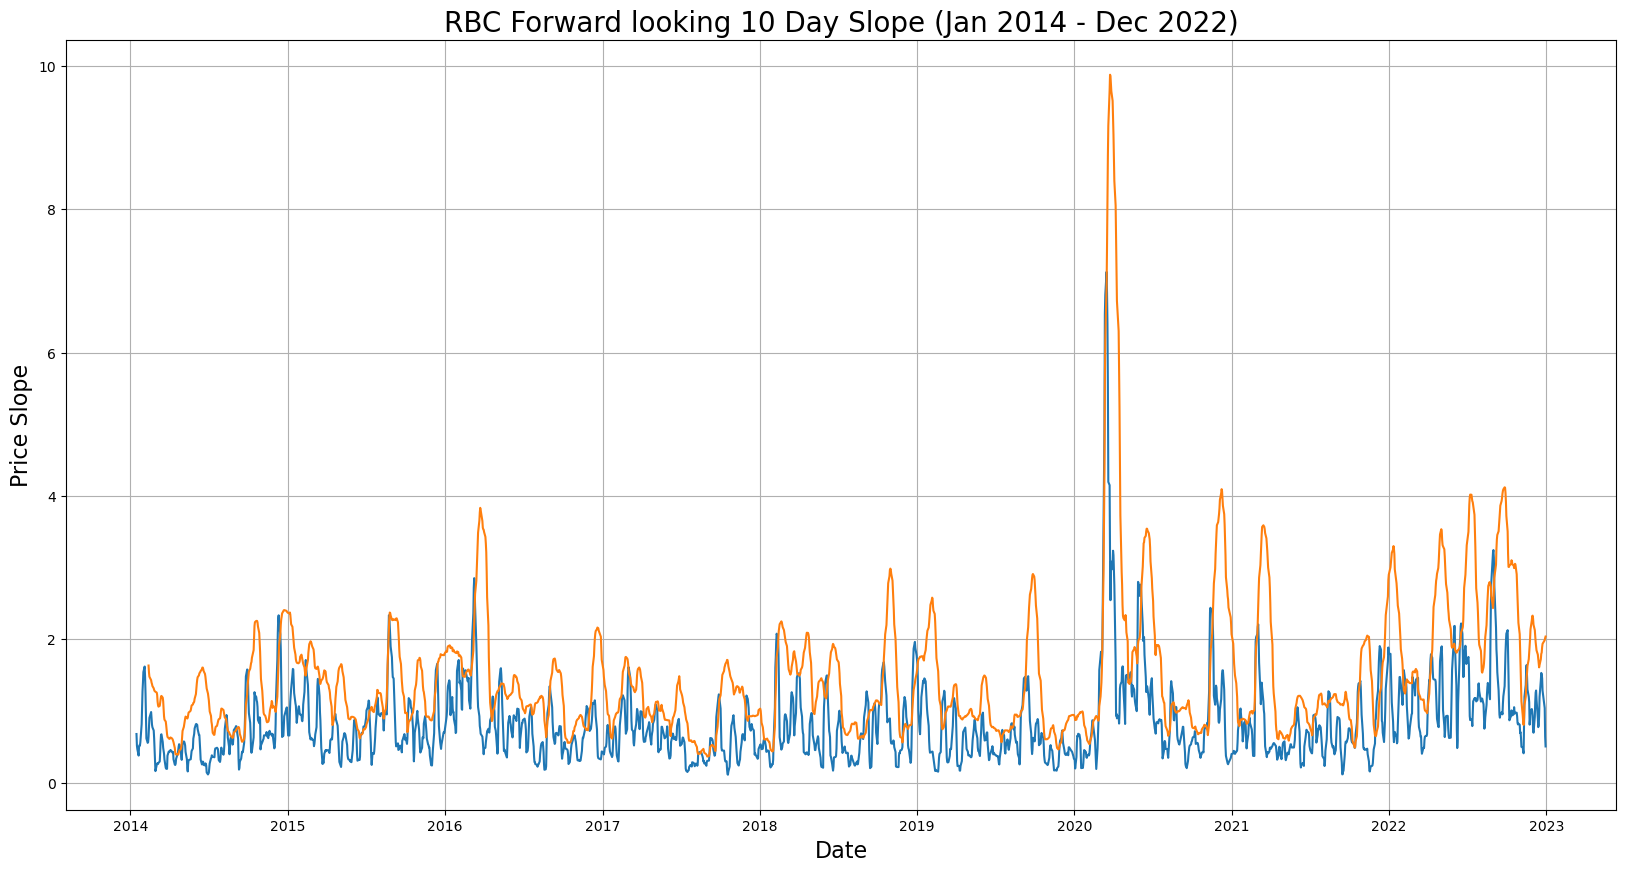

In [6]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Std_Dev_10Day_Moc']], label='High')
plt.plot(df[['Std_Dev_30Day_Moc']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [7]:
# Prepare df for trend determination
df = df.sort_index()
df = df.reset_index()
df

Date       Open       High        Low      Close  \
0    2014-01-02 00:00:00-05:00  66.349998  66.599998  66.010002  66.010002   
1    2014-01-03 00:00:00-05:00  65.239998  65.519997  64.860001  65.459999   
2    2014-01-06 00:00:00-05:00  65.459999  65.489998  64.529999  64.739998   
3    2014-01-07 00:00:00-05:00  64.949997  65.139999  64.470001  64.480003   
4    2014-01-08 00:00:00-05:00  64.550003  64.660004  64.120003  64.400002   
...                        ...        ...        ...        ...        ...   
2253 2022-12-22 00:00:00-05:00  65.540001  65.849998  64.919998  65.820000   
2254 2022-12-23 00:00:00-05:00  65.940002  66.400002  65.849998  66.379997   
2255 2022-12-28 00:00:00-05:00  66.480003  66.680000  65.320000  65.440002   
2256 2022-12-29 00:00:00-05:00  65.599998  66.669998  65.459999  66.629997   
2257 2022-12-30 00:00:00-05:00  66.500000  66.610001  65.769997  66.339996   

      Adj Close    Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0     42.832870   2724600  66.305000  66.180000  66.242500  ...   
1     42.878716   1498600  65.189999  65.349998  65.269999  ...   
2     42.407093   1937000  65.009998  65.099998  65.054998  ...   
3     42.236786   1455100  64.805000  64.715000  64.760000  ...   
4     42.184380   2014100  64.390003  64.475002  64.432503  ...   
...         ...       ...        ...        ...        ...  ...   
2253  64.798073   5739000  65.384998  65.680000  65.532499  ...   
2254  65.349380   3687900  66.125000  66.160000  66.142500  ...   
2255  64.423981  13099800  66.000000  65.960003  65.980001  ...   
2256  65.595497   9330200  66.064999  66.114998  66.089998  ...   
2257  65.309998   4108200  66.189999  66.419998  66.304998  ...   

      Returns_5Day_Mhloc  Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
0                    NaN                  NaN                NaN   
1                    NaN                  NaN                NaN   
2                    NaN                  NaN                NaN   
3                    NaN                  NaN                NaN   
4                    NaN                  NaN                NaN   
...                  ...                  ...                ...   
2253           -0.003952            -0.039500           1.458194   
2254            0.013717            -0.039534           1.284387   
2255            0.017268            -0.037561           1.041283   
2256            0.014195            -0.044977           0.645756   
2257            0.005917            -0.039928           0.506338   

      Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  Std_Dev_30Day_Mhloc  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
...                 ...                  ...                  ...   
2253           1.892037             1.429305             1.871339   
2254           1.938117             1.244257             1.917702   
2255           1.989476             1.033543             1.967234   
2256           2.019962             0.648633             2.000240   
2257           2.039363             0.479775             2.022680   

      SMA_Returns_8Day_Mhloc  SMA_Returns_20Day_Mhloc  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                        NaN                      NaN   
...                      ...                      ...   
2253                0.010272                 0.008145   
2254                0.011099                 0.008361   
2255                0.009561                 0.008277   
2256                0.006754                 0.007959   
2257       

In [8]:
# Calculate the 10-day forward looking slope of daily price benchmarks 
# Slope = coefecient from sklearn regression model
# Price Benchmarks = high, low, open, close

# Initialize X variable 1-10 
X = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])

# Initialize results dataframe
df_target_y = pd.DataFrame(columns = ['index', 'high_slope','high_intercept', 'mid_hl_slope', 'mid_hl_intercept', 'mid_oc_slope', 'mid_oc_intercept', 'low_slope', 'low_intercept', 'trend_10day'])

# Calculate from 1st to last less 10 days
for i in range(len(df) - 10):
    
    # Initialize y variables
    trend = 10
    y_High = np.array([])
    y_Mid_hl = np.array([])
    y_Mid_oc = np.array([])
    y_Low = np.array([])
    count = 0
    
    # Calculate y variables and add them to the array
    for j in range (i , i + 10):
        y_High = np.insert(y_High, len(y_High), df['High'].iloc[[j]])
        y_Mid_hl = np.insert(y_Mid_hl, len(y_Mid_hl), (df['High'].iloc[[j]] + df['Low'].iloc[[j]])/2)
        y_Mid_oc = np.insert(y_Mid_oc, len(y_Mid_oc), (df['Open'].iloc[[j]] + df['Close'].iloc[[j]])/2)
        y_Low = np.insert(y_Low, len(y_Low), df['Low'].iloc[[j]])
        count += 1
    
    # Reshape the y array for the regression model   
    y_High = y_High.reshape(-1,1)
    y_Mid_hl = y_Mid_hl.reshape(-1,1)
    y_Mid_oc = y_Mid_oc.reshape(-1,1)
    y_Low = y_Low.reshape(-1,1)
    
    # Regression models
    reg_High = LinearRegression().fit(X, y_High)
    reg_Mid_hl = LinearRegression().fit(X, y_Mid_hl)
    reg_Mid_oc = LinearRegression().fit(X, y_Mid_oc)
    reg_Low = LinearRegression().fit(X, y_Low)
    
    # Determine trend 
    # 0 - Down = 3 negative coefecients or 2 negative and the sum of all 4 is negative
    # 1 - Up   = 3 positive coefecients or 2 positive and the sum of all 4 is positive
    if (reg_High.coef_ > 0 and reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0): 
        trend = 1
    elif (reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ < 0 and reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0):
        trend = 0
    elif (reg_High.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0): 
        trend = 0
    elif (reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0):
        trend = 0
    elif (reg_High.coef_  + reg_Mid_hl.coef_ + reg_Mid_oc.coef_ + reg_Low.coef_ > 0):
        trend = 1    
    else: 
        trend =0
    
    # Populate result dataframe
    df_temp = pd.DataFrame({"index":i,  "high_slope": reg_High.coef_[0],     "high_intercept": reg_High.intercept_[0], 
                                        "mid_hl_slope": reg_Mid_hl.coef_[0], "mid_hl_intercept": reg_Mid_hl.intercept_[0],
                                        "mid_oc_slope": reg_Mid_oc.coef_[0], "mid_oc_intercept": reg_Mid_oc.intercept_[0], 
                                        "low_slope": reg_Low.coef_[0],       "low_intercept": reg_Low.intercept_[0],
                                        "trend_10day": trend})
    
    df_target_y = pd.concat([df_target_y,df_temp], axis = "rows")
    
    #print(f" row {i} xxx High: {reg_High.coef_} xxx Mid HiLo: {reg_Mid_hl.coef_} xxx Mid OpCl: {reg_Mid_oc.coef_} xxx Low: {reg_Low.coef_} xxx {trend}")
    #print('========================')

# Display result Dataframe
df_target_y = df_target_y.set_index(['index'])
display(df_target_y)

C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


high_slope  high_intercept  mid_hl_slope  mid_hl_intercept  \
index                                                               
0       -0.219030       66.196665     -0.208485         65.832666   
1       -0.176303       65.682665     -0.159515         65.293333   
2       -0.164121       65.458667     -0.145333         65.069334   
3       -0.084182       64.958002     -0.093273         64.714002   
4        0.040909       64.356003      0.010212         64.200335   
...           ...             ...           ...               ...   
2243    -0.396545       69.489999     -0.403818         68.939000   
2244    -0.406727       69.296000     -0.392727         68.619001   
2245    -0.323273       68.592000     -0.274879         67.733335   
2246    -0.208182       67.762000     -0.166727         66.936001   
2247    -0.029758       66.522666     -0.012818         65.867001   

       mid_oc_slope  mid_oc_intercept  low_slope  low_intercept trend_10day  
index                                                                        
0         -0.208394         65.861666  -0.197940      65.468668           0  
1         -0.165606         65.379333  -0.142727      64.904000           0  
2         -0.149576         65.124667  -0.126545      64.680000           0  
3         -0.092121         64.736668  -0.102364      64.470001           0  
4          0.002394         64.282335  -0.020485      64.044667           1  
...             ...               ...        ...            ...         ...  
2243      -0.440303         69.142667  -0.411091      68.388000           0  
2244      -0.404485         68.702667  -0.378727      67.942002           0  
2245      -0.290697         67.848333  -0.226485      66.874669           0  
2246      -0.163788         66.907333  -0.125273      66.110003           0  
2247      -0.001303         65.789667   0.004121      65.211336           0  

[2248 rows x 9 columns]

In [9]:
df = pd.concat([df, df_target_y], axis= 1)
display(df.head(11))
display(df.tail(11))

Date       Open       High        Low      Close  \
0  2014-01-02 00:00:00-05:00  66.349998  66.599998  66.010002  66.010002   
1  2014-01-03 00:00:00-05:00  65.239998  65.519997  64.860001  65.459999   
2  2014-01-06 00:00:00-05:00  65.459999  65.489998  64.529999  64.739998   
3  2014-01-07 00:00:00-05:00  64.949997  65.139999  64.470001  64.480003   
4  2014-01-08 00:00:00-05:00  64.550003  64.660004  64.120003  64.400002   
5  2014-01-09 00:00:00-05:00  64.589996  64.650002  64.129997  64.510002   
6  2014-01-10 00:00:00-05:00  64.690002  64.720001  64.279999  64.430000   
7  2014-01-13 00:00:00-05:00  64.370003  64.660004  64.150002  64.269997   
8  2014-01-14 00:00:00-05:00  64.489998  64.500000  63.669998  63.680000   
9  2014-01-15 00:00:00-05:00  63.910000  63.980000  63.580002  63.730000   
10 2014-01-16 00:00:00-05:00  63.810001  63.810001  63.400002  63.610001   

    Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0   42.832870  2724600  66.305000  66.180000  66.242500  ...   
1   42.878716  1498600  65.189999  65.349998  65.269999  ...   
2   42.407093  1937000  65.009998  65.099998  65.054998  ...   
3   42.236786  1455100  64.805000  64.715000  64.760000  ...   
4   42.184380  2014100  64.390003  64.475002  64.432503  ...   
5   42.256432  1332300  64.389999  64.549999  64.469999  ...   
6   42.204033  1187800  64.500000  64.560001  64.530001  ...   
7   42.099228  1371900  64.405003  64.320000  64.362501  ...   
8   41.712749  1905200  64.084999  64.084999  64.084999  ...   
9   41.745499  1943000  63.780001  63.820000  63.800000  ...   
10  41.666912  1453500  63.605001  63.710001  63.657501  ...   

    SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
0                          1   -0.219030       66.196665     -0.208485   
1                          1   -0.176303       65.682665     -0.159515   
2                          1   -0.164121       65.458667     -0.145333   
3                          1   -0.084182       64.958002     -0.093273   
4                          1    0.040909       64.356003      0.010212   
5                          1    0.063030       64.257336      0.038394   
6                          1    0.056060       64.272669      0.041273   
7                          1    0.044000       64.286001      0.019758   
8                          0   -0.034364       64.544000     -0.082454   
9                          0   -0.146061       64.921333     -0.196212   
10                         0   -0.288242       65.473333     -0.316545   

    mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
0          65.832666     -0.208394         65.861666  -0.197940   
1          65.293333     -0.165606         65.379333  -0.142727   
2          65.069334     -0.149576         65.124667  -0.126545   
3          64.714002     -0.092121         64.736668  -0.102364   
4          64.200335      0.002394         64.282335  -0.020485   
5          64.067334      0.038606         64.109667   0.013758   
6          64.032001      0.050151         64.016667   0.026485   
7          64.057334      0.023394         64.055333  -0.004485   
8          64.379000     -0.070030         64.367666  -0.130545   
9          64.760667     -0.178697         64.743333  -0.246364   
10         65.180000     -0.299394         65.172667  -0.344849   

    low_intercept  trend_10day  
0       65.468668            0  
1       64.904000            0  
2       64.680000            0  
3       64.470001            0  
4       64.044667            1  
5       63.877332            1  
6       63.791333            1  
7       63.828667            1  
8       64.214000            0  
9       64.600001            0  
10      64.886667            0  

[11 rows x 34 columns]

Date       Open       High        Low      Close  \
2247 2022-12-14 00:00:00-05:00  67.629997  67.949997  66.480003  66.620003   
2248 2022-12-15 00:00:00-05:00  66.199997  66.400002  65.070000  65.500000   
2249 2022-12-16 00:00:00-05:00  65.050003  65.720001  64.980003  65.239998   
2250 2022-12-19 00:00:00-05:00  65.320000  65.580002  64.059998  64.480003   
2251 2022-12-20 00:00:00-05:00  64.910004  65.949997  64.510002  65.290001   
2252 2022-12-21 00:00:00-05:00  65.720001  66.389999  65.690002  65.860001   
2253 2022-12-22 00:00:00-05:00  65.540001  65.849998  64.919998  65.820000   
2254 2022-12-23 00:00:00-05:00  65.940002  66.400002  65.849998  66.379997   
2255 2022-12-28 00:00:00-05:00  66.480003  66.680000  65.320000  65.440002   
2256 2022-12-29 00:00:00-05:00  65.599998  66.669998  65.459999  66.629997   
2257 2022-12-30 00:00:00-05:00  66.500000  66.610001  65.769997  66.339996   

      Adj Close    Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
2247  65.585655   5126400  67.215000  67.125000  67.170000  ...   
2248  64.483040  10736800  65.735001  65.849998  65.792500  ...   
2249  64.227081  11494100  65.350002  65.145000  65.247501  ...   
2250  63.478882   9698700  64.820000  64.900002  64.860001  ...   
2251  64.276306   5032700  65.230000  65.100002  65.165001  ...   
2252  64.837456   1713200  66.040001  65.790001  65.915001  ...   
2253  64.798073   5739000  65.384998  65.680000  65.532499  ...   
2254  65.349380   3687900  66.125000  66.160000  66.142500  ...   
2255  64.423981  13099800  66.000000  65.960003  65.980001  ...   
2256  65.595497   9330200  66.064999  66.114998  66.089998  ...   
2257  65.309998   4108200  66.189999  66.419998  66.304998  ...   

      SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
2247                         0   -0.029758       66.522666     -0.012818   
2248                         0         NaN             NaN           NaN   
2249                         0         NaN             NaN           NaN   
2250                         0         NaN             NaN           NaN   
2251                         0         NaN             NaN           NaN   
2252                         0         NaN             NaN           NaN   
2253                         0         NaN             NaN           NaN   
2254                         0         NaN             NaN           NaN   
2255                         0         NaN             NaN           NaN   
2256                         0         NaN             NaN           NaN   
2257                         0         NaN             NaN           NaN   

      mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
2247         65.867001     -0.001303         65.789667   0.004121   
2248               NaN           NaN               NaN        NaN   
2249               NaN           NaN               NaN        NaN   
2250               NaN           NaN               NaN        NaN   
2251               NaN           NaN               NaN        NaN   
2252               NaN           NaN               NaN        NaN   
2253               NaN           NaN               NaN        NaN   
2254               NaN           NaN               NaN        NaN   
2255               NaN           NaN               NaN        NaN   
2256               NaN           NaN               NaN        NaN   
2257               NaN           NaN               NaN        NaN   

      low_intercept  trend_10day  
2247      65.211336            0  
2248            NaN          NaN  
2249            NaN          NaN  
2250            NaN          NaN  
2251            NaN          NaN  
2252            NaN          NaN  
2253            NaN          NaN  
2254            NaN          NaN  
2255            NaN          NaN  
2256            NaN          NaN  
2257            NaN          NaN  

[11 rows x 34 columns]

In [10]:
df = df.set_index(['Date'])
display(df.head(11))
display(df.tail(11))


Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  66.349998  66.599998  66.010002  66.010002   
2014-01-03 00:00:00-05:00  65.239998  65.519997  64.860001  65.459999   
2014-01-06 00:00:00-05:00  65.459999  65.489998  64.529999  64.739998   
2014-01-07 00:00:00-05:00  64.949997  65.139999  64.470001  64.480003   
2014-01-08 00:00:00-05:00  64.550003  64.660004  64.120003  64.400002   
2014-01-09 00:00:00-05:00  64.589996  64.650002  64.129997  64.510002   
2014-01-10 00:00:00-05:00  64.690002  64.720001  64.279999  64.430000   
2014-01-13 00:00:00-05:00  64.370003  64.660004  64.150002  64.269997   
2014-01-14 00:00:00-05:00  64.489998  64.500000  63.669998  63.680000   
2014-01-15 00:00:00-05:00  63.910000  63.980000  63.580002  63.730000   
2014-01-16 00:00:00-05:00  63.810001  63.810001  63.400002  63.610001   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  42.832870  2724600  66.305000  66.180000   
2014-01-03 00:00:00-05:00  42.878716  1498600  65.189999  65.349998   
2014-01-06 00:00:00-05:00  42.407093  1937000  65.009998  65.099998   
2014-01-07 00:00:00-05:00  42.236786  1455100  64.805000  64.715000   
2014-01-08 00:00:00-05:00  42.184380  2014100  64.390003  64.475002   
2014-01-09 00:00:00-05:00  42.256432  1332300  64.389999  64.549999   
2014-01-10 00:00:00-05:00  42.204033  1187800  64.500000  64.560001   
2014-01-13 00:00:00-05:00  42.099228  1371900  64.405003  64.320000   
2014-01-14 00:00:00-05:00  41.712749  1905200  64.084999  64.084999   
2014-01-15 00:00:00-05:00  41.745499  1943000  63.780001  63.820000   
2014-01-16 00:00:00-05:00  41.666912  1453500  63.605001  63.710001   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2014-01-02 00:00:00-05:00  66.242500        0.000000  ...   
2014-01-03 00:00:00-05:00  65.269999        0.909094  ...   
2014-01-06 00:00:00-05:00  65.054998        0.218749  ...   
2014-01-07 00:00:00-05:00  64.760000        0.014929  ...   
2014-01-08 00:00:00-05:00  64.432503        0.518515  ...   
2014-01-09 00:00:00-05:00  64.469999        0.730773  ...   
2014-01-10 00:00:00-05:00  64.530001        0.340911  ...   
2014-01-13 00:00:00-05:00  64.362501        0.235284  ...   
2014-01-14 00:00:00-05:00  64.084999        0.012051  ...   
2014-01-15 00:00:00-05:00  63.800000        0.374996  ...   
2014-01-16 00:00:00-05:00  63.657501        0.512193  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2014-01-02 00:00:00-05:00                         1   -0.219030   
2014-01-03 00:00:00-05:00                         1   -0.176303   
2014-01-06 00:00:00-05:00                         1   -0.164121   
2014-01-07 00:00:00-05:00                         1   -0.084182   
2014-01-08 00:00:00-05:00                         1    0.040909   
2014-01-09 00:00:00-05:00                         1    0.063030   
2014-01-10 00:00:00-05:00                         1    0.056060   
2014-01-13 00:00:00-05:00                         1    0.044000   
2014-01-14 00:00:00-05:00                         0   -0.034364   
2014-01-15 00:00:00-05:00                         0   -0.146061   
2014-01-16 00:00:00-05:00                         0   -0.288242   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2014-01-02 00:00:00-05:00       66.196665     -0.208485         65.832666   
2014-01-03 00:00:00-05:00       65.682665     -0.159515         65.293333   
2014-01-06 00:00:00-05:00       65.458667     -0.145333         65.069334   
2014-01-07 00:00:00-05:00       64.958002     -0.093273         64.714002   
2014-01-08 00:00:00-05:00     

Open       High        Low      Close  \
Date                                                                    
2022-12-14 00:00:00-05:00  67.629997  67.949997  66.480003  66.620003   
2022-12-15 00:00:00-05:00  66.199997  66.400002  65.070000  65.500000   
2022-12-16 00:00:00-05:00  65.050003  65.720001  64.980003  65.239998   
2022-12-19 00:00:00-05:00  65.320000  65.580002  64.059998  64.480003   
2022-12-20 00:00:00-05:00  64.910004  65.949997  64.510002  65.290001   
2022-12-21 00:00:00-05:00  65.720001  66.389999  65.690002  65.860001   
2022-12-22 00:00:00-05:00  65.540001  65.849998  64.919998  65.820000   
2022-12-23 00:00:00-05:00  65.940002  66.400002  65.849998  66.379997   
2022-12-28 00:00:00-05:00  66.480003  66.680000  65.320000  65.440002   
2022-12-29 00:00:00-05:00  65.599998  66.669998  65.459999  66.629997   
2022-12-30 00:00:00-05:00  66.500000  66.610001  65.769997  66.339996   

                           Adj Close    Volume     Mid_hl     Mid_oc  \
Date                                                                   
2022-12-14 00:00:00-05:00  65.585655   5126400  67.215000  67.125000   
2022-12-15 00:00:00-05:00  64.483040  10736800  65.735001  65.849998   
2022-12-16 00:00:00-05:00  64.227081  11494100  65.350002  65.145000   
2022-12-19 00:00:00-05:00  63.478882   9698700  64.820000  64.900002   
2022-12-20 00:00:00-05:00  64.276306   5032700  65.230000  65.100002   
2022-12-21 00:00:00-05:00  64.837456   1713200  66.040001  65.790001   
2022-12-22 00:00:00-05:00  64.798073   5739000  65.384998  65.680000   
2022-12-23 00:00:00-05:00  65.349380   3687900  66.125000  66.160000   
2022-12-28 00:00:00-05:00  64.423981  13099800  66.000000  65.960003   
2022-12-29 00:00:00-05:00  65.595497   9330200  66.064999  66.114998   
2022-12-30 00:00:00-05:00  65.309998   4108200  66.189999  66.419998   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2022-12-14 00:00:00-05:00  67.170000        0.095238  ...   
2022-12-15 00:00:00-05:00  65.792500        0.323308  ...   
2022-12-16 00:00:00-05:00  65.247501        0.351345  ...   
2022-12-19 00:00:00-05:00  64.860001        0.276319  ...   
2022-12-20 00:00:00-05:00  65.165001        0.541668  ...   
2022-12-21 00:00:00-05:00  65.915001        0.242856  ...   
2022-12-22 00:00:00-05:00  65.532499        0.967743  ...   
2022-12-23 00:00:00-05:00  66.142500        0.963629  ...   
2022-12-28 00:00:00-05:00  65.980001        0.088237  ...   
2022-12-29 00:00:00-05:00  66.089998        0.966941  ...   
2022-12-30 00:00:00-05:00  66.304998        0.678568  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2022-12-14 00:00:00-05:00                         0   -0.029758   
2022-12-15 00:00:00-05:00                         0         NaN   
2022-12-16 00:00:00-05:00                         0         NaN   
2022-12-19 00:00:00-05:00                         0         NaN   
2022-12-20 00:00:00-05:00                         0         NaN   
2022-12-21 00:00:00-05:00                         0         NaN   
2022-12-22 00:00:00-05:00                         0         NaN   
2022-12-23 00:00:00-05:00                         0         NaN   
2022-12-28 00:00:00-05:00                         0         NaN   
2022-12-29 00:00:00-05:00                         0         NaN   
2022-12-30 00:00:00-05:00                         0         NaN   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2022-12-14 00:00:00-05:00       66.522666     -0.012818         65.867001   
2022-12-15 00:00:00-05:00             NaN           NaN               NaN   
2022-12-16 00:00:00-05:00             NaN           NaN               NaN   
2022-12-19 00:00:00-05:00             NaN           NaN               NaN   
2022-12-20 00:00:

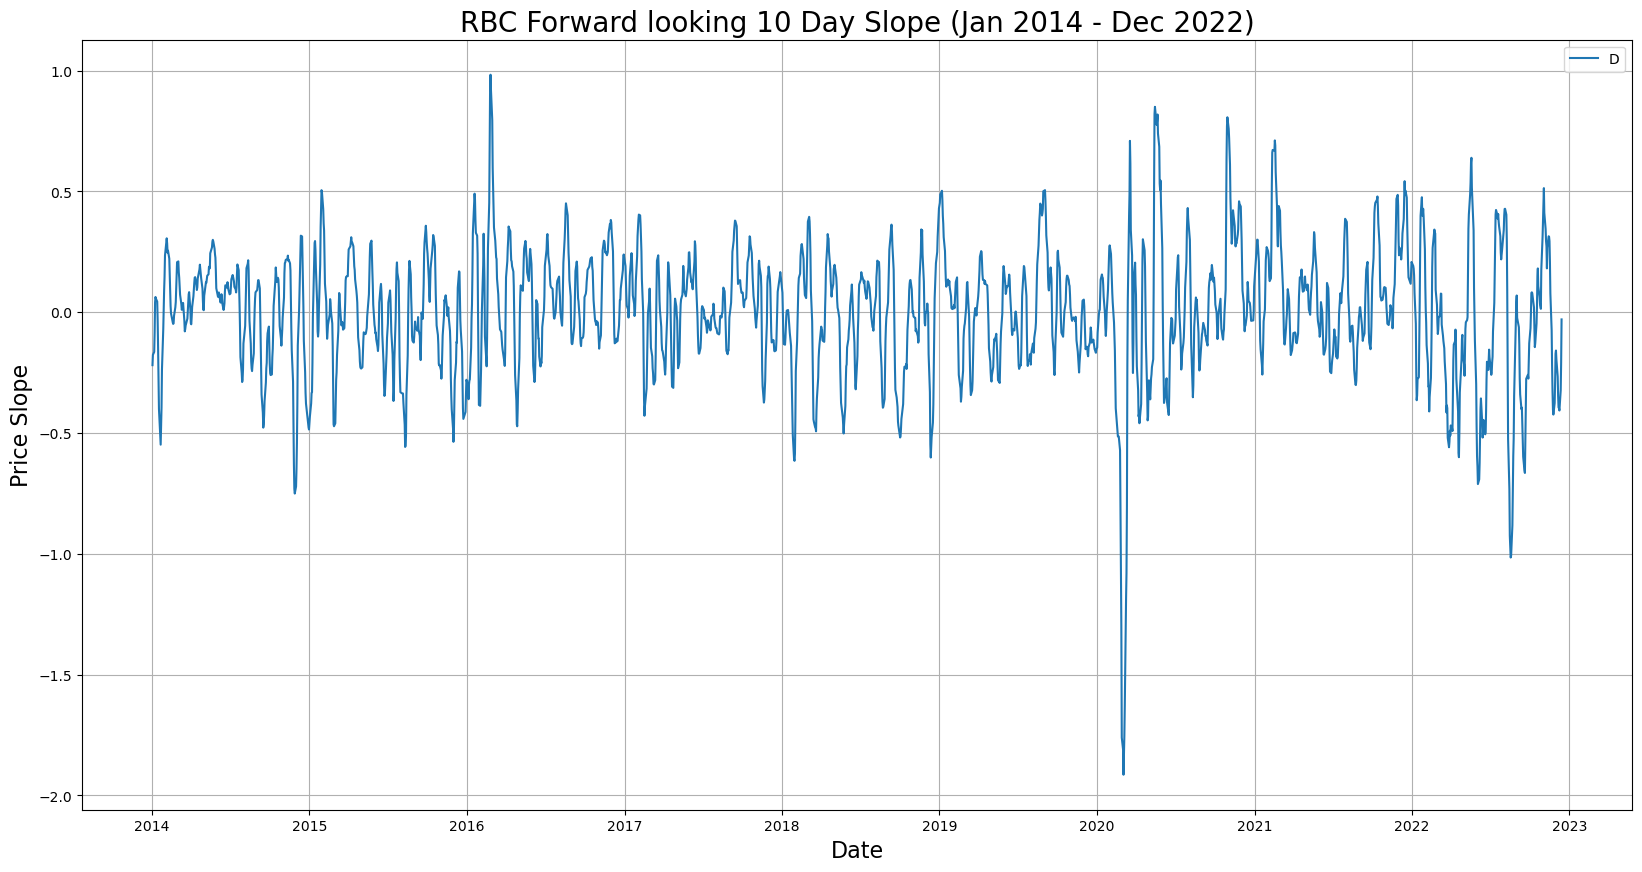

In [11]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['high_slope']])
#plt.title("Bank of Montreal (BMO) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend('Daily High')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [12]:
df.to_csv('../Data/Feature_Engineering_BNS.csv', encoding='utf-8')